# Create one coloc network per locus

In [173]:
library(pheatmap)
library(colorspace)


In [174]:
setwd("/frazer01/projects/CARDIPS/analysis/cardiac_gwas_coloc")

source("script/functions.R"  )


In [175]:
dir.create("pipeline/5.2.coloc_network", showWarnings = FALSE)


In [176]:
manifest   = add_rownames(fread("pipeline/1.1.sumstats/manifest.txt"                     , sep = "\t", header = TRUE, data.table = FALSE))
loci       = add_rownames(fread("pipeline/1.2.genomewide_significant_loci/loci.txt"      , sep = "\t", header = TRUE, data.table = FALSE))
loci2study = add_rownames(fread("pipeline/1.2.genomewide_significant_loci/loci2study.txt", sep = "\t", header = TRUE, data.table = FALSE))
coloc_gwas =              fread("pipeline/2.1.coloc/coloc.txt"                           , sep = "\t", header = TRUE, data.table = FALSE)
coloc_qtls =              fread("pipeline/4.1.coloc_qtls/coloc.txt"                      , sep = "\t", header = TRUE, data.table = FALSE)

In [177]:
manifest    = manifest[ !manifest$description %in% c("K57 Diverticular disease of intestine", "Cataract", "M16 Coxarthrosis [arthrosis of hip]"), ]
loci2study  = loci2study[,rownames(manifest)]
loci2study  = loci2study[ rowSums(loci2study) > 0,]
loci        = loci[rownames(loci2study),]
loci$n_gwas = rowSums(loci2study)


In [278]:
str(manifest)

'data.frame':	27 obs. of  42 variables:
 $ trait_type                    : chr  "biomarkers" "biomarkers" "biomarkers" "biomarkers" ...
 $ phenocode                     : chr  "30600" "30680" "30690" "30760" ...
 $ pheno_sex                     : chr  "both_sexes" "both_sexes" "both_sexes" "both_sexes" ...
 $ coding                        : int  NA NA NA NA NA NA 1140861958 1140866738 1140879802 1141146234 ...
 $ modifier                      : chr  "irnt" "irnt" "irnt" "irnt" ...
 $ description                   : chr  "Albumin" "Calcium" "Cholesterol" "HDL cholesterol" ...
 $ description_more              : chr  "" "" "" "" ...
 $ coding_description            : chr  "" "" "" "" ...
 $ category                      : chr  "Biological samples > Assay results > Blood assays > Blood biochemistry" "Biological samples > Assay results > Blood assays > Blood biochemistry" "Biological samples > Assay results > Blood assays > Blood biochemistry" "Biological samples > Assay results > Blood ass

In [178]:
qtl_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/qtl/qtls.RDS"   )
exp_list = readRDS("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/input/expdata_qtl.rds")

In [179]:
phenotypes  = qtl_list$phenotypes
qtls        = qtl_list$qtl
coordinates = exp_list$coordinates
rownames(coordinates) = coordinates$transcript_id

In [180]:
populations = c('meta','AFR','AMR','CSA','EAS','EUR','MID')

In [181]:
coloc_qtls = merge(coloc_qtls, coordinates[,c("transcript_id", "gene_id", "gene_name", "phenotype")], by = "transcript_id")

# Get coloc between QTLs

In [182]:
coloc_data  = fread("/frazer01/projects/CARDIPS/analysis/cardiac_qtls_combined/pipeline/coloc/processing/coloc.txt", sep = "\t", header = TRUE, data.table = FALSE)
nodes_all   = merge(coordinates[ coordinates$transcript_id %in% unique(c(coloc_data$transcript_id1, coloc_data$transcript_id2, coloc_qtls$transcript_id)),], qtl_list$phenotypes[,c("phenotype", "color")])[,c("transcript_id", "gene_id", "gene_name", "transcript_type", "gene_type", "phenotype", "chrom", "start", "end", "color")]
edges_all   = coloc_data[, c("transcript_id1", "transcript_id2", "type1", "type2", "id", "pp_snp", paste("PP.H", 0:4, ".abf", sep = ""))]
#network_all = graph_from_data_frame(d = edges_all, vertices = nodes_all, directed = FALSE)
edges_all$pop = "meta"

# Combine into one single data frame
- nodes
- edges

## GWAS vs. GWAS

In [183]:
nodes_gwas     = data.frame(transcript_id = manifest$id, gene_id = manifest$id, gene_name = manifest$name, gene_type = "GWAs", transcript_type = "GWAs", phenotype = "gwas", color = "#ff0000")
nodes_gwas     = merge(nodes_gwas, data.frame(locus_id = rownames(loci), chrom = paste0("chr", loci$chrom), start = loci$from, end = loci$to))
#nodes_gwas$gws = FALSE
#
#for(transcript_id in colnames(loci2study))
#{
#    ids = rownames(loci2study[ loci2study[, transcript_id] == 1,])
#    nodes_gwas[ nodes_gwas$transcript_id == transcript_id & nodes_gwas$locus_id %in% ids, "gws"] = TRUE
#}
#
#nodes_gwas = nodes_gwas[ nodes_gwas$gws == TRUE, ]




In [184]:
edges_gwas_locus = lapply(loci$locus, function(locus)
{
    x                = coloc_gwas[ coloc_gwas$locus == locus, ]
    mycols           = c("transcript_id1", "transcript_id2", "type1", "type2", "pop", "id", "pp_snp", paste("PP.H", 0:4, ".abf", sep = ""))
    x$transcript_id1 = x$study1
    x$transcript_id2 = x$study2
    x$type1          = 0
    x$type2          = 0
    x$id             = x$variant_id
    x                = x[,mycols]
    
    return(x)
})

names(edges_gwas_locus) = loci$locus

## GWAS vs. QTL

In [185]:
edges_gwas_qtl_locus = lapply(loci$locus, function(locus)
{
    x                = coloc_qtls[ coloc_qtls$locus == locus, ]
    if(nrow(x) > 0)
    {
        mycols           = c("transcript_id1", "transcript_id2", "type1", "type2", "pop", "id", "pp_snp", paste("PP.H", 0:4, ".abf", sep = ""))
        x$transcript_id1 = x$transcript_id
        x$transcript_id2 = x$gwas
        x$type1          = x$type
        x$type2          = 0
        x                = x[,mycols]

        return(x)
    }else
    {
        return(data.frame())
    }
})

names(edges_gwas_qtl_locus) = loci$locus

# Create network for each locus

In [186]:
suppressPackageStartupMessages(library(igraph  ))
suppressPackageStartupMessages(library(corrplot))

In [187]:
loci$n_qtls = unlist(lapply(edges_gwas_qtl_locus, nrow))

In [200]:
create_network_locus = function(locus, threshold = 0.5)
{
    chrom           = paste0("chr", loci  [locus , "chrom" ])
    from            =               loci  [locus , "from"  ]
    to              =               loci  [locus , "to"    ]
    gwas_gwas       = edges_gwas_locus    [[locus]]
    gwas_qtls       = edges_gwas_qtl_locus[[locus]]
    transcript_ids  = sort(unique(c(gwas_qtls$transcript_id1, gwas_qtls$transcript_id2, gwas_gwas$transcript_id1, gwas_gwas$transcript_id2)))
    qtls_qtls       = edges_all[ edges_all$transcript_id1 %in% transcript_ids & edges_all$transcript_id2 %in% transcript_ids,]
    edges           = rbind(gwas_gwas, gwas_qtls, qtls_qtls)
    nodes           = rbind(nodes_all, nodes_gwas[ nodes_gwas$locus_id == locus, colnames(nodes_all)])
    edges           = edges[ edges$PP.H4.abf >= threshold,]
    nodes           = unique(nodes[ nodes$transcript_id %in% c(edges$transcript_id1, edges$transcript_id2),])
    network         = graph_from_data_frame(d = edges, vertices = nodes, directed = FALSE)
    
    return(list(nodes = nodes, edges = edges, network = network))
}

#locus = loci[2, "locus"]
x = create_network_locus("1_72412988_73058905", 0.9)

loci2net            = loci[ loci$n_qtls > 0 | loci$n_gwas > 1,]
loci_network        = lapply(loci2net$locus, function(locus){create_network_locus(locus, 0.9)})
names(loci_network) = loci2net$locus

saveRDS(loci_network, "pipeline/5.2.coloc_network/network_by_locus.rds")
fwrite(loci2net, "pipeline/5.2.coloc_network/loci2net.txt", sep = "\t", col.names = TRUE, row.names = FALSE)



# Get all associations (PP-h4 > 0.5 or PP-h3 > 0.5)

In [250]:
get_pps = function(locus, threshold = 0.5)
{
    chrom           = paste0("chr", loci  [locus , "chrom" ])
    from            =               loci  [locus , "from"  ]
    to              =               loci  [locus , "to"    ]
    gwas_gwas       = edges_gwas_locus    [[locus]]
    gwas_qtls       = edges_gwas_qtl_locus[[locus]]
    transcript_ids  = sort(unique(c(gwas_qtls$transcript_id1, gwas_qtls$transcript_id2, gwas_gwas$transcript_id1, gwas_gwas$transcript_id2)))
    qtls_qtls       = edges_all[ edges_all$transcript_id1 %in% transcript_ids & edges_all$transcript_id2 %in% transcript_ids,]
    edges           = rbind(gwas_gwas, gwas_qtls, qtls_qtls)
    nodes           = rbind(nodes_all, nodes_gwas[ nodes_gwas$locus_id == locus, colnames(nodes_all)])
    edges           = edges[ edges$PP.H4.abf >= threshold | edges$PP.H3.abf >= threshold,]
    nodes           = unique(nodes[ nodes$transcript_id %in% c(edges$transcript_id1, edges$transcript_id2),])
    
    return(list(nodes = nodes, edges = edges))
}

#locus = loci[2, "locus"]
x = get_pps("1_72412988_73058905", 0.5)

top_pps        = lapply(loci2net$locus, function(locus){get_pps(locus, 0.5)})
names(top_pps) = loci2net$locus

saveRDS(top_pps, "pipeline/5.2.coloc_network/top_pps.rds")


In [266]:
loci2net_count = as.data.frame(rbindlist(lapply(top_pps, function(x)
{
    nodes = x$nodes
    edges = x$edges
    out = data.frame(nodes = nrow(nodes), 
                     edges = nrow(unique(edges[, c("transcript_id1", "transcript_id2")])), 
                     nodes_09 = length(unique(c(edges[edges$PP.H4.abf >= 0.9, "transcript_id1"], edges[edges$PP.H4.abf >= 0.9, "transcript_id2"]))),
                     edges_09 = nrow(unique(edges[edges$PP.H4.abf >= 0.9, c("transcript_id1", "transcript_id2")]))
                    )
    for(phenotype in c("gwas", phenotypes$phenotype))
    {
        out[,paste("nodes", phenotype, sep = ".")] = nrow(nodes[nodes$phenotype == phenotype,])
    }
    
    return(out)
})), stringsAsFactors = FALSE)

loci2net_count = cbind(loci2net[,c("locus", "size", "chrom", "from", "to", "ids", "n_gwas")], loci2net_count)

fwrite(loci2net_count, "pipeline/5.2.coloc_network/loci2net_count.txt", sep = "\t", col.names = TRUE, row.names = FALSE)


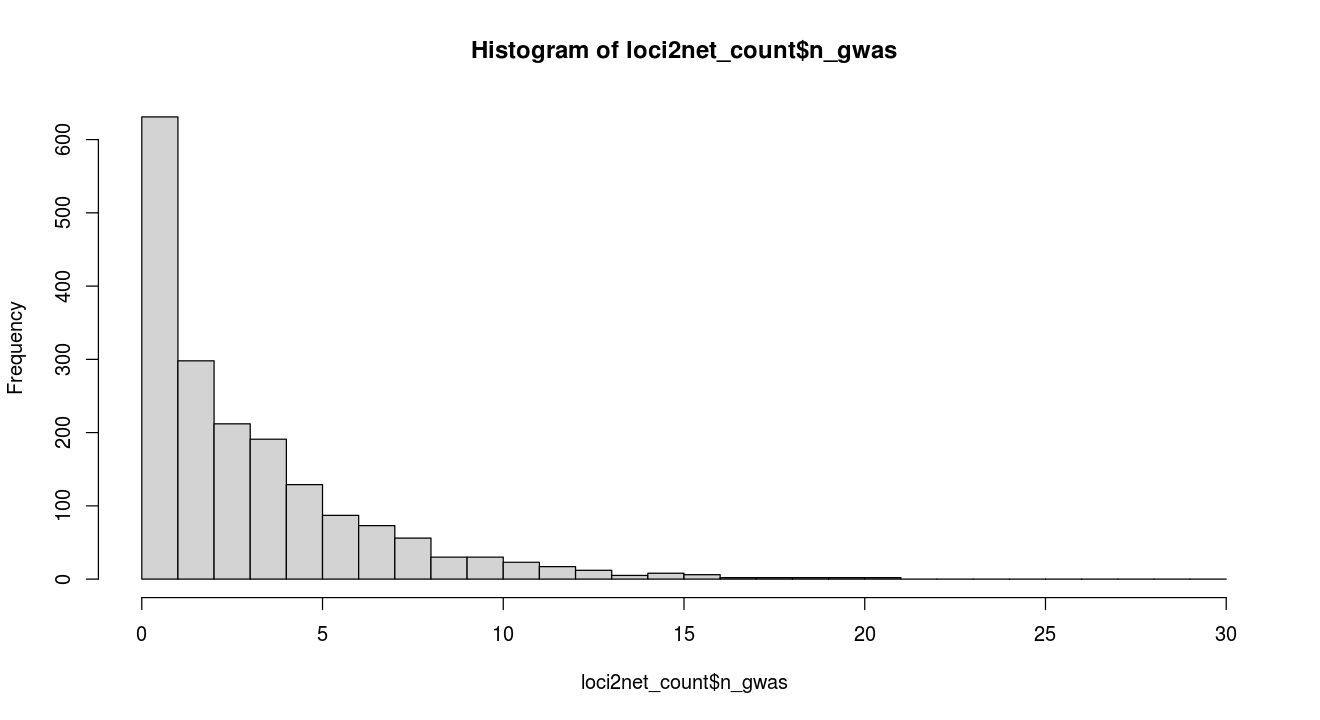

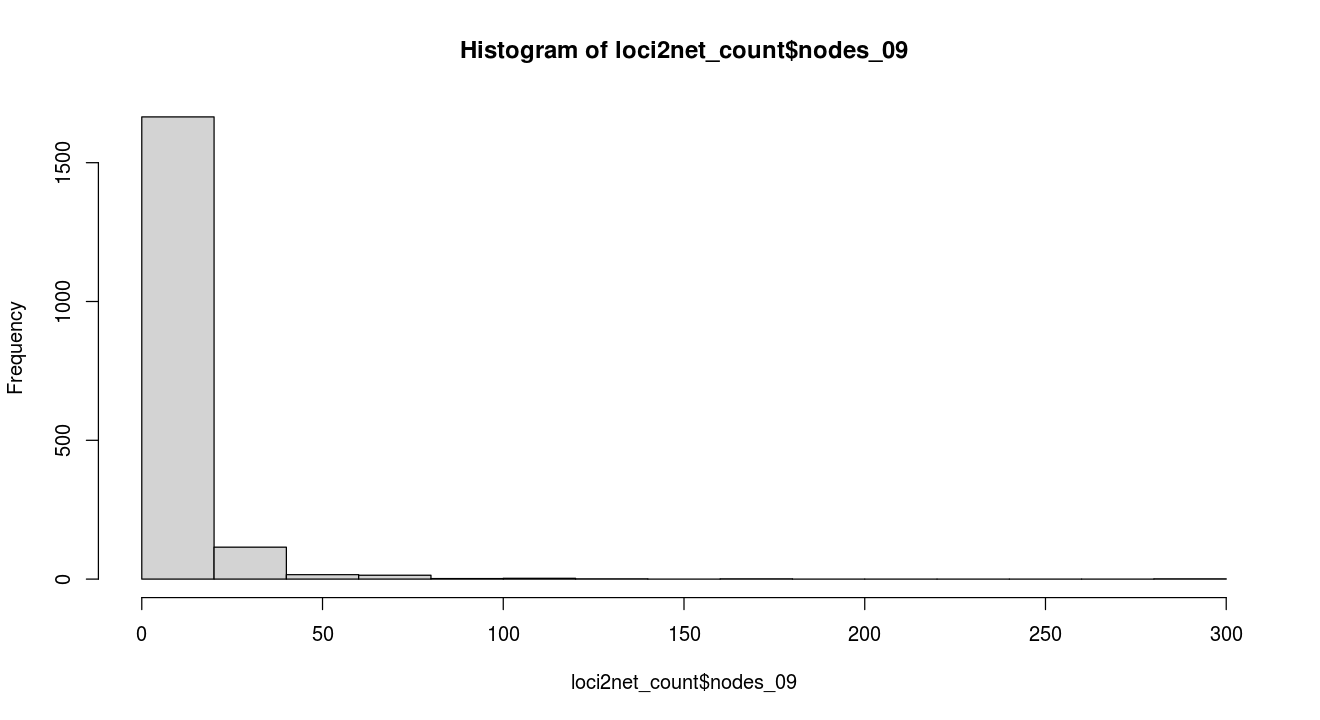

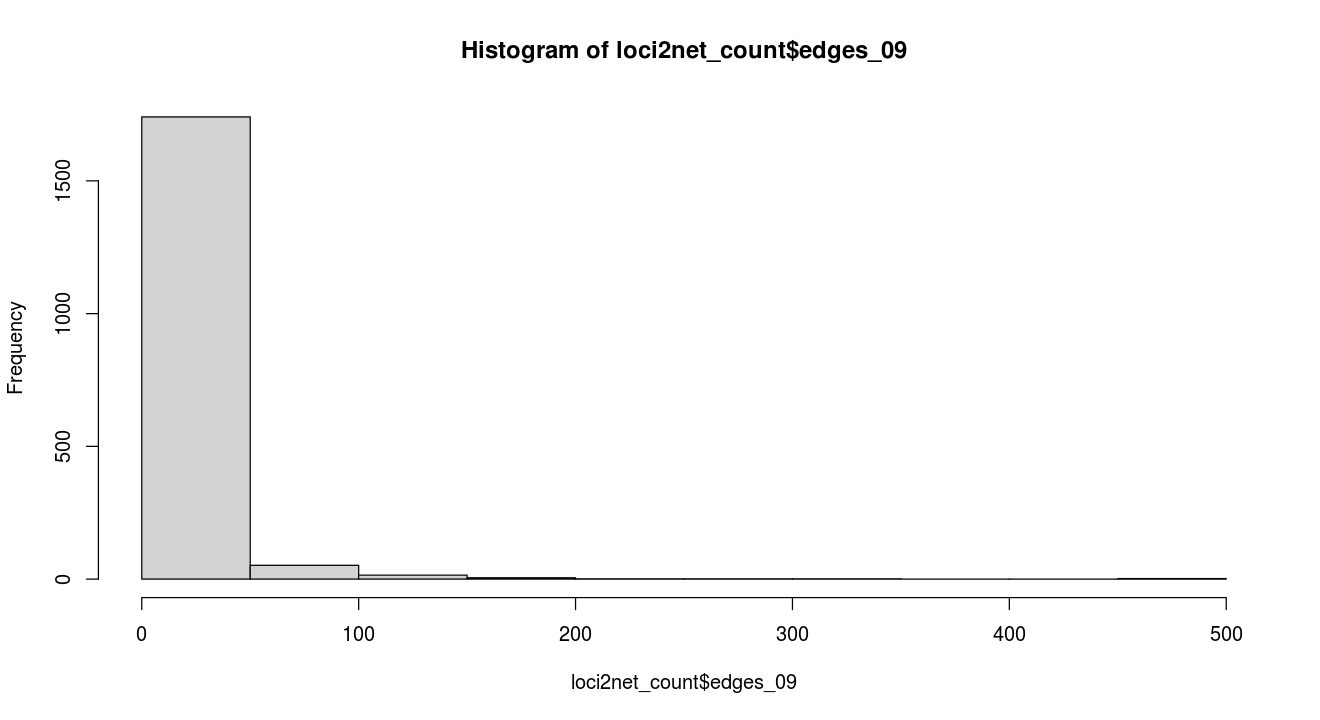

In [272]:
hist(loci2net_count$n_gwas, breaks = 0:30)
hist(loci2net_count$nodes_09)
hist(loci2net_count$edges_09)



In [273]:
head(loci2net_count[order(loci2net_count$edges_09, decreasing = TRUE),])

,locus,size,chrom,from,to,ids,n_gwas,nodes,edges,nodes_09,edges_09,nodes.gwas,nodes.rna,nodes.isoform,nodes.atac,nodes.chip
,<chr>,<int>,<int>,<int>,<int>,<chr>,<dbl>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>,<int>
6_25044242_33934568,6_25044242_33934568,8890326,6,25044242,33934568,"biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30690-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,biomarkers-30780-both_sexes-irnt,biomarkers-30870-both_sexes-irnt,categorical-20003-both_sexes-1140861958,continuous-102-both_sexes-irnt,continuous-20022-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-DBP-both_sexes-combined_medadj_irnt,continuous-LDLC-both_sexes-medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt,icd10-I20-both_sexes,icd10-I25-both_sexes,phecode-401-both_sexes,phecode-411.4-both_sexes",19,406,15752,286,473,27,161,163,18,37
17_40144007_48070076,17_40144007_48070076,7926069,17,40144007,48070076,"biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30690-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,biomarkers-30780-both_sexes-irnt,biomarkers-30870-both_sexes-irnt,categorical-20003-both_sexes-1140861958,continuous-102-both_sexes-irnt,continuous-12340-both_sexes-irnt,continuous-20022-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-DBP-both_sexes-combined_medadj_irnt,continuous-LDLC-both_sexes-medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt,icd10-I20-both_sexes,icd10-I25-both_sexes,phecode-401-both_sexes,phecode-411.2-both_sexes,phecode-411.4-both_sexes",21,279,4844,166,461,27,104,76,40,32
16_14277712_16384360,16_14277712_16384360,2106648,16,14277712,16384360,"biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,biomarkers-30870-both_sexes-irnt,continuous-102-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-DBP-both_sexes-combined_medadj_irnt,continuous-LDLC-both_sexes-medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",11,89,1567,75,321,17,25,34,9,4
1_965800_2544414,1_965800_2544414,1578614,1,965800,2544414,"biomarkers-30600-both_sexes-irnt,biomarkers-30680-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt",7,126,2644,85,269,15,50,32,10,19
19_43889535_47004800,19_43889535_47004800,3115265,19,43889535,47004800,"biomarkers-30600-both_sexes-irnt,biomarkers-30690-both_sexes-irnt,biomarkers-30760-both_sexes-irnt,biomarkers-30780-both_sexes-irnt,biomarkers-30870-both_sexes-irnt,categorical-20003-both_sexes-1140861958,categorical-20003-both_sexes-1141146234,continuous-102-both_sexes-irnt,continuous-21001-both_sexes-irnt,continuous-DBP-both_sexes-combined_medadj_irnt,continuous-LDLC-both_sexes-medadj_irnt,continuous-MAP-both_sexes-combined_medadj_irnt,continuous-PP-both_sexes-combined_medadj_irnt,continuous-SBP-both_sexes-combined_medadj_irnt,icd10-I20-both_sexes,icd10-I25-both_sexes,phecode-411.2-both_sexes,phecode-411.4-both_sexes",18,164,3145,107,215,24,61,48,14,17
22_24141101_24503541,22_24141101_24503541,362440,22,24141101,24503541,biomarkers-30870-both_sexes-irnt,1,44,415,36,200,7,12,6,8,11


# plot networks

In [277]:
plot_subgraph = function(locus)
{
    network_locus = loci_network[[locus]]
    nodes         = network_locus$nodes
    edges         = network_locus$edges
    x             = network_locus$network
    coord         = nodes[nodes$transcript_id %in% names(V(x)),]
    chrom         = unique(coord$chrom)
    from          = min   (coord$start)
    to            = max   (coord$end  )
    ids           = nodes
    ids           = ids[order(ids$start),]
    
    toplot = as.data.frame(matrix(0, nrow = nrow(ids), ncol = nrow(ids), dimnames = list(ids$transcript_id, ids$transcript_id)))
    
    for(ii in 1:(nrow(ids)-1))
    {
        id1 = ids[ii, "transcript_id"]
        
        for(jj in (ii+1):nrow(ids))
        {
            id2  = ids[jj, "transcript_id"]
            this = edges[ (edges$transcript_id1 == id1 & edges$transcript_id2 == id2) | (edges$transcript_id1 == id2 & edges$transcript_id2 == id1),]
            
            if(nrow(this) > 0)
            {
                #toplot[c(id1, id2), c(id2, id1)] =  max(this[, "PP.H4.abf"])
                toplot[id1, id2] =  max(this[, "PP.H4.abf"])
            }
        }
        toplot[ii,ii] = 1
    }
    
    toplot           = as.matrix(toplot)
    rownames(toplot) = ids$gene_name
    colnames(toplot) = ids$gene_name
    
    layout(rbind(1:2))
    corrplot(toplot, method = "color", tl.pos = "t", tl.cex = 0.8, tl.col = "#000000")
    plot.igraph(x, vertex.label = V(x)$gene_name, main = locus)
    
    #return(toplot)
}
options(repr.plot.width = 20, repr.plot.height = 8)

toplot = loci2net_count[ loci2net_count$edges_09 > 0,]

pdf(file = "pipeline/5.2.coloc_network/network_loci.pdf", width = 20, height = 9)
invisible(lapply(toplot[order(toplot$edges_09, decreasing = TRUE), "locus"], plot_subgraph))

dev.off()

#toplot = plot_subgraph(decomposed, 409)


png 
  2